In [1]:
%%capture
#!pip install sweetviz
#sweet_report = sv.analyze(df)
#sweet_report.show_html('sweet_report.html')
!pip install pyclustering
!pip install tqdm
!pip install python-dotenv
!pip install seaborn
!pip install beautifulsoup4
!pip install country-named-entity-recognition
!pip install flickrapi
!pip install geopy
!pip install datasketch
!pip install lightfm




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#import networkx as nx
#from networkx.algorithms import community
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure

from sklearn.metrics.pairwise import cosine_similarity
import time
import psutil
from datasketch import MinHash, MinHashLSH



from multiprocessing import process
from re import M
from typing import Counter
import requests
from bs4 import BeautifulSoup
import os
from country_named_entity_recognition import find_countries
import flickrapi
from geopy.geocoders import Nominatim
import json
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
import math
import lightfm
from lightfm import LightFM
import scipy.sparse as sparse

from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs


Loading API keys for flickr, if data is not already in folder. Downloading the data from the github again will not be possible, as it requires
a specific API key to be loaded in a .env file kept in the same folder as your library.

In [3]:
##START OF FLICKR PART
def configure():
    load_dotenv()
    
current_path = os.getcwd()
saving_filepath = '/datasets/flickr/cities_coord.json'

if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
    configure()

# Getting the data

### NomadList data

In [4]:
#Loading csv's
def get_data(filepath):
    current_path = os.getcwd()
    df = pd.read_csv(current_path+filepath)
    return df


Importing nomadlist dataset and SDG dataset

In [5]:
filepath_nomadlist = '/datasets/nomadlist/cities_predict.csv'
df_nomadlist = get_data(filepath_nomadlist)

##IMPORTING SDG DATA
filepath_SDG = "/datasets/SDG_CSV/SDGData.csv"
df_SDG = get_data(filepath_SDG)
df_SDG = df_SDG[['Country Code', 'Country Name', 'Indicator Name', '2015']]
df_SDG = df_SDG.dropna()

### Flickr data

The following code retrieves a correspondence between city names and their coordinates.

This is needed to retrieve the correct data from flickr

In [6]:
def get_city_name_from_nomadlist(df_nomadlist):
    cities = df_nomadlist['place_slug']
    countries = df_nomadlist['country']
    cities_list = []
    for city, country in zip(cities, countries):
        number_of_country_words = len(country.split(' '))
        city_name = ' '.join(city.split('-')[:-number_of_country_words])
        cities_list.append(city_name)

    cities_list = sorted(cities_list)
    return cities_list

def get_geoloc_per_city(cities_list, saving_filepath):
    current_path = os.getcwd()
    geolocator = Nominatim(user_agent='myapplication')
    cities_coord = {}

    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        cities_coord = json.load(f)
    else:
        for city in tqdm(cities_list):
            location = geolocator.geocode(city)
            lat = location.raw['lat']
            lon = location.raw['lon']
            cities_coord[city] = (lat, lon)

        with open('cities_coord.json', 'w') as fp:
            json.dump(cities_coord, fp)
    return cities_coord

Retrieving users and photos they have taken in the cities from the nomadlist dataset

To do this, we used Flickr API's which need a secret API key and secret.
Nonetheless, the code is still executable since all the useful data was stored in json files.

In [7]:
def get_flickr_data(cities_coord, saving_filepath):
    current_path = os.getcwd()
    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        users = json.load(f)
    else:
        flickr = flickrapi.FlickrAPI(os.getenv('api_key'), os.getenv('api_secret'), format='parsed-json')
        extras = ['description','tags','url_sq', 'url_t', 'url_s', 'url_q', 'url_m', 'url_n', 'url_z', 'url_c', 'url_l', 'url_o']
        users = {}
        for city, coords in tqdm(cities_coord.items()): 
            try:
                images = flickr.photos.search(text='travel', lat = coords[0], lon = coords[1], radius = '30', radius_units = 'km', extras=extras)
                for image in images['photos']['photo']:
                    user = image['owner']
                    if user in users.keys():
                        users[user].append(city)
                    else:
                        users[user] = [city]
            except:
                print(f'Images for {city} not found or another error encountered')

            with open(saving_filepath, 'w') as fp:
                json.dump(users, fp)
    return users

In [8]:
cities_list = get_city_name_from_nomadlist(df_nomadlist)

#Flickr part
saving_filepath = '/datasets/flickr/cities_coord.json'
cities_coord = get_geoloc_per_city(cities_list, saving_filepath)
saving_filepath = '/datasets/flickr/users.json'
users_raw = get_flickr_data(cities_coord, saving_filepath)

# Process data

At first we also tried getting some country data from the Sustainable Development Goals dataset. This dataset collects a lot of data about countries, so we thought some could be useful to infer insight about cities that was not already in the nomadlist dataset. As it turns out, only 3 columns matched the countries in our dataset without having missing values, so we are using the three of them, which are:
* Access to electricity (% of population),
* Access to electricity, urban (% of urban population),
* Renewable electricity output (% of total electricity output)


In [9]:
def merge_data_by_country(df_nomadlist, df_SDG):
    filtered_country_df_nomadlist = df_nomadlist['country'].unique()
    country_codes = {find_countries(country)[0][0].alpha_3: country for country in filtered_country_df_nomadlist if find_countries(country)}

    #Skim the SDG dataset
    for code in country_codes.keys():
        df_SDG.loc[df_SDG['Country Code'] == code, 'Country Name'] = country_codes[code]

    df_SDG = df_SDG.loc[df_SDG['Country Name'].isin(filtered_country_df_nomadlist)]
    number_of_countries = len(df_SDG['Country Code'].unique())

    #Finding columns that preserve all data, i.e. that are shared by every city
    df_SDG_count = df_SDG.groupby(['Indicator Name']).count()
    common_indicators = df_SDG_count[df_SDG_count['2015'] == number_of_countries].reset_index()['Indicator Name']
    df_SDG = df_SDG.loc[df_SDG['Indicator Name'].isin(common_indicators)]


    #Actually merge the data
    df_SDG = df_SDG[['Country Name', 'Indicator Name', '2015']]
    df_SDG = df_SDG.pivot(index = 'Country Name', columns = 'Indicator Name', values = '2015')

    df_SDG = df_SDG.reset_index()
    df_SDG_cleaned = df_SDG.rename(columns={'Country Name': 'country'})

    df_nomadlist = df_nomadlist.merge(df_SDG_cleaned, how='outer', on='country')
    return df_nomadlist

In [10]:
df_nomadlist = merge_data_by_country(df_nomadlist, df_SDG)

In the following, we build the data structures that will allow us to use the flickr data.

There is __users__:
* Dictionary 
* userIDs as key
* list of cities they took photo in as value (with repetitions, if one took 5 photos in mexico city, then mexico city would appear 5 times in the list)

and __users_cities_rating__:
* Dictionary of dictionaries
* key is usersID
* value is dict of city rating, having:
    - city name as key
    - normalized number of photos in that city, normalization is done user per user


In [11]:
def process_data(raw_users):
    users_cities_rating = {}
    number_of_values = 0
    users = {}
    for key, value in raw_users.items():
        uniques = set(value)
        avg_pics_per_place = len(value)/len(uniques)
        city_count = Counter(value)
        maximum_city = max(city_count, key=city_count.get)
        maximum_pics_per_user = city_count[maximum_city]
        #Normalization
        #We want a rating from 0 to 5
        for item, count in city_count.items():
            city_count[item] = math.ceil(city_count[item]/(maximum_pics_per_user/5))
            #city_count[item] /= avg_pics_per_place

        users_cities_rating[key] = city_count

        users[key] = uniques
        number_of_values += len(users[key])

    return users, users_cities_rating

In [12]:
users, users_cities_rating = process_data(users_raw)

## EDA

In [13]:
df = df_nomadlist
df.isnull().sum()

df.duplicated().sum()
df.head()

,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,...,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug,Access to electricity (% of population),"Access to electricity, urban (% of urban population)",Renewable electricity output (% of total electricity output)
0,492.0,4.0,42.0,946.0,1.0,0.70,1.40,3.0,961.0,626.0,...,3.0,4.0,4.0,4.03,Latin America,Mexico,mexico-city-mexico,99.0,99.300003,15.394134
1,223.0,3.0,19.0,976.0,1.0,0.63,1.11,3.0,697.0,349.0,...,3.0,4.0,4.0,4.51,Latin America,Mexico,cancun-mexico,99.0,99.300003,15.394134
2,367.0,2.0,54.0,2074.0,1.0,0.66,1.94,3.0,1072.0,512.0,...,3.0,4.0,1.0,3.54,Latin America,Mexico,tulum-mexico,99.0,99.300003,15.394134
3,369.0,2.0,53.0,1617.0,1.0,0.61,1.23,3.0,938.0,483.0,...,3.0,4.0,4.0,4.17,Latin America,Mexico,playa-del-carmen-mexico,99.0,99.300003,15.394134
4,216.0,4.0,41.0,641.0,1.0,0.67,1.54,3.0,627.0,380.0,...,3.0,4.0,4.0,4.20,Latin America,Mexico,guadalajara-mexico,99.0,99.300003,15.394134


In [14]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Latin America'

# Methodologies

### Clustering

In [15]:
def plot3dClusterRepresentation(df, num_cols = 4, hasClusterColumn = True):
    # Create a grid of subplots with 4 plots per line
    num_rows = int(np.ceil(len(range(0, 360, 30)) / num_cols))
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows), subplot_kw={'projection': '3d'})

    # Iterate over different angles
    for i, angle in enumerate(range(0, 360, 30)):
        row_index = i // num_cols
        col_index = i % num_cols

        if hasClusterColumn:
        # Scatter plot points by cluster
            for cluster in range(num_clusters):
                  cluster_data = df[df['Cluster'] == cluster]
                  axes[row_index, col_index].scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'], label=f'Cluster {cluster + 1}')
        else:
            axes[row_index, col_index].scatter(df['PCA1'], df['PCA2'], df['PCA3'])

        axes[row_index, col_index].set_xlabel('PCA1')
        axes[row_index, col_index].set_ylabel('PCA2')
        axes[row_index, col_index].set_zlabel('PCA3')
        axes[row_index, col_index].set_title(f'3D Scatter Plot of Clusters (Angle: {angle}°')

        # Set the viewing angle
        axes[row_index, col_index].view_init(30, angle)

        # Show the legend in the first plot of each row
        if col_index == 0:
            axes[row_index, col_index].legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    return plt.show()

In [16]:
## remove cost of living both columns
columns_to_drop = ['coca-cola','adult_nightlife','coffee','region', 'place_slug','country','cost_of_living_for_expat','1br_studio_rent_in_center','airbnb_(monthly)']
df_for_clustering = df.drop(columns=columns_to_drop)
df_for_clustering['cost_of_living_for_local'] = - df_for_clustering['cost_of_living_for_local']
df_for_clustering.head()

,air_quality_(year-round),cashless_society,cost_of_living,cost_of_living_for_local,female_friendly,freedom_of_speech,friendly_to_foreigners,fun,happiness,healthcare,...,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score,Access to electricity (% of population),"Access to electricity, urban (% of urban population)",Renewable electricity output (% of total electricity output)
0,42.0,1.0,3.0,-626.0,2.0,1.0,3.0,3.0,3.0,2.0,...,0.0,0.0,1.0,3.0,4.0,4.0,4.03,99.0,99.300003,15.394134
1,19.0,1.0,3.0,-349.0,2.0,1.0,3.0,4.0,3.0,2.0,...,0.0,0.0,2.0,3.0,4.0,4.0,4.51,99.0,99.300003,15.394134
2,54.0,1.0,3.0,-512.0,1.0,1.0,1.0,2.0,3.0,2.0,...,1.0,0.0,1.0,3.0,4.0,1.0,3.54,99.0,99.300003,15.394134
3,53.0,1.0,3.0,-483.0,2.0,1.0,4.0,3.0,3.0,2.0,...,0.0,0.0,1.0,3.0,4.0,4.0,4.17,99.0,99.300003,15.394134
4,41.0,1.0,3.0,-380.0,2.0,1.0,3.0,2.0,3.0,2.0,...,0.0,0.0,1.0,3.0,4.0,4.0,4.20,99.0,99.300003,15.394134


In [17]:
scaler = MinMaxScaler((1,5))
normalized_features = scaler.fit_transform(df_for_clustering)

# Round the normalized values to whole numbers
rounded_features = pd.DataFrame(normalized_features).round()

In [18]:
df_for_clustering23D = rounded_features.copy()

# Apply k-means clustering
num_clusters = 4 # You can choose the number of clusters based on your needs
kmeans_23D = KMeans(n_clusters=num_clusters, random_state=42)
df_for_clustering23D['Cluster'] = kmeans_23D.fit_predict(df_for_clustering23D.values)

# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
df_for_clustering23D_pca = pca.fit_transform(df_for_clustering23D.values)

# Create a DataFrame with the PCA components and the cluster labels
df_pca_cluster = pd.DataFrame(data=df_for_clustering23D_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_cluster['Cluster'] = df_for_clustering23D['Cluster']

plot3dClusterRepresentation(df_pca_cluster,4)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Extract the features from the DataFrame
X = rounded_features.values

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])

plot3dClusterRepresentation(df_pca,4,False)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 12)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)

    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Apply k-means clustering
num_clusters = 5  # You can choose the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PCA1', 'PCA2', 'PCA3']])

plot3dClusterRepresentation(df_pca,4)

In [ ]:
# Add cluster assignments back to the original DataFrame
df['Cluster'] = df_pca['Cluster']

num_clusters = 6

for cluster in range(num_clusters):
    cluster_cities = df[df['Cluster'] == cluster].nlargest(5, 'nomad_score')
    plt.scatter(
        cluster_cities['place_slug'],
        cluster_cities['nomad_score'],
        label=f'Cluster {cluster + 1}',
        alpha=0.7,
        s=cluster_cities['nomad_score'] * 10  # Adjust the multiplier based on the desired marker size
    )

# Set labels and title
plt.title('Top 5 Cities with Color-Coded Clusters and Marker Size Based on Nomad Score')
plt.xlabel('place_slug')
plt.ylabel('nomad_score')

# Display legend
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Fix temp['place_slug'] format
temp = df[['place_slug','country','Cluster']].copy()

for i in range(len(temp['place_slug'])):
    number_of_country_words = len(temp['country'][i].split(' '))
    temp.loc[i, 'place_slug'] = ' '.join(temp['place_slug'][i].split('-')[:-number_of_country_words])

# Load JSON data
with open('cities_coord.json', 'r') as file:
    data = json.load(file)

# Create a DataFrame from the JSON data
df_cities_coord = pd.DataFrame.from_dict(data, orient='index', columns=['Latitude', 'Longitude']).reset_index()
df_cities_coord = df_cities_coord.rename(columns={'index': 'place_slug'})

df_map_plot = pd.merge(df_cities_coord, temp, how='inner', on='place_slug')


# Convert the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_map_plot['Longitude'].astype(float), df_map_plot['Latitude'].astype(float))]
gdf = GeoDataFrame(df_map_plot, geometry=geometry)

fig, ax = plt.subplots(figsize=(10, 6))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray')

# Create a color map for clusters
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
cluster_colors = dict(zip(gdf['Cluster'].unique(), colors))


# Plot each cluster with a different color
for cluster, color in cluster_colors.items():
    subset = gdf[gdf['Cluster'] == cluster]
    subset.plot(ax=ax, marker='o', color=color, markersize=10, label=f'Cluster {cluster}', alpha=0.7)

# Add legend with ordered labels
ordered_labels = sorted(gdf['Cluster'].unique())
legend_labels = [f'Cluster {cluster+1}' for cluster in ordered_labels]
ax.legend(labels=legend_labels)

plt.show()

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [5, 10, 15],
}

best_score = -1
best_params = {}

# Perform grid search
for n_clusters in param_grid['n_clusters']:
    for affinity in param_grid['affinity']:
        for n_neighbors in param_grid['n_neighbors']:
            model = SpectralClustering(
                n_clusters=n_clusters,
                affinity=affinity,
                n_neighbors=n_neighbors,
                random_state=42
            )
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels)

            print(f"Parameters: n_clusters={n_clusters}, affinity={affinity}, n_neighbors={n_neighbors}, Score: {score}")

            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'n_neighbors': n_neighbors}

print(f"Best parameters: {best_params}, Best silhouette score: {best_score}")


In [ ]:
# Number of clusters (you may need to adjust this)
n_clusters = 4

# Create a spectral clustering model
spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)

# Fit the model and get cluster assignments
labels = spectral.fit_predict(X_pca)

plot3dClusterRepresentation(labels,4)



In [ ]:
# Standardize the features
X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune DBSCAN parameters
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [ 40, 45, 50, 75, 100, 200, 300]

best_score = float('inf')  # Initialize with a high value
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)

        # Check if there are at least two clusters for Davies-Bouldin Index
        if len(np.unique(dbscan_labels)) >= 2:
            silhouette = davies_bouldin_score(X_pca, dbscan_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune Agglomerative Clustering parameters
n_clusters_values = [ 4, 5, 6, 7, 8, 9, 10]
linkage_methods = [ 'complete', 'average']
affinity_metrics = ['euclidean', 'cosine']

best_score = float('inf')  # Initialize with a high value
best_params = {}

for n_clusters in n_clusters_values:
    for linkage in linkage_methods:
        for affinity in affinity_metrics:
            agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)
            agglomerative_labels = agglomerative.fit_predict(X_pca)

            silhouette = davies_bouldin_score(X_pca, agglomerative_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['n_clusters'] = n_clusters
                best_params['linkage'] = linkage
                best_params['metric'] = affinity

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Calculate the linkage matrix
# You may need to adjust the method and metric based on your specific case
# More information: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_matrix = linkage(X_pca, method='average', metric='euclidean')


# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the dendrogram
dendrogram(linkage_matrix)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [ ]:

X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=40)
dbscan_labels = dbscan.fit_predict(X_pca)

# CURE
# Note: CURE is not directly available in scikit-learn, and you may need to use external libraries or implement it manually.

# Hierarchical Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10, linkage='average')
agglomerative_labels = agglomerative.fit_predict(X_pca)


# Evaluate clusters using Davies-Bouldin index
agglomerative_davies_bouldin = davies_bouldin_score(X_pca, agglomerative_labels)
dbscan_davies_bouldin = davies_bouldin_score(X_pca, dbscan_labels)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample

# Standardize the features
X_standardized = MinMaxScaler((-2,2)).fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)


# Number of clusters you want to obtain
num_clusters = 4

# CURE clustering
cure_instance = cure(data=X_pca,number_represent_points=50, number_cluster=num_clusters, compression=0.8)
cure_instance.process()

# Get cluster labels
cure_clusters = cure_instance.get_clusters()

# Visualize clusters (2D visualization)
visualizer = cluster_visualizer()
visualizer.append_clusters(cure_clusters, X_pca)
visualizer.show()

In [ ]:
import pandas as pd

# Columns to generate data for
columns_to_fill = [
    'air_quality_(year-round)', 'cashless_society', 'cost_of_living',
    'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners', 'fun', 'happiness',
    'healthcare', 'peace', 'quality_of_life', 'racial_tolerance', 'religious_government',
    'safe_tap_water', 'safety', 'startup_score', 'traffic_safety', 'walkability'
]

# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 5.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 5.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 3.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0 # Assuming moderate walkability
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)
from sklearn.metrics.pairwise import cosine_similarity

# Add back the column labels to the rounded features
rounded_features.columns = df_for_clustering.columns

sub = rounded_features[columns_to_fill]

# Calculate cosine similarity matrix for items (rows)
item_similarity_matrix = cosine_similarity(sub,user_profile_df)

# Find the most similar item
most_similar_item_index = np.argmax(item_similarity_matrix)

# Display the most similar item and its cluster
most_similar_item_cluster = df.loc[most_similar_item_index, 'Cluster']

print(f"The most similar item is in Cluster: {most_similar_item_cluster}")
print("Details of the most similar item:")
print(df.iloc[most_similar_item_index])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == most_similar_item_cluster]

# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='cost_of_living', ascending=False).head(5)
print(f"Top 5 items within Cluster {most_similar_item_cluster} by rating:")
print(top_5_items)

In [ ]:
# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 3.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 4.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'internet': 5.0,
    'lgbt_friendly': 2.0,
    'nightlife': 2.0,
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 5.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0, # Assuming moderate walkability
    'nomad_score': 2.0
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)

# Apply PCA with 3 components
X_pca = pca.transform(user_profile_df.values)

# Now, let's say you have a new user with preferences
new_user_preferences = np.random.rand(1, 3)

# Assign the user to the nearest cluster
user_cluster = kmeans.predict(X_pca)

# Print the result
print("User belongs to Cluster:", user_cluster[0])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == user_cluster[0]]


# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='nomad_score', ascending=False)
print(df[df['Cluster'] == 0])

## Similar Items

In [19]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

First of all we need to normalize the columns

For this part of the report the nomad_sdg dataset is used.

In [20]:
df = pd.read_csv('datasets/nomadlist/df_nomad_sdg.csv')

In [21]:
df.shape

(730, 35)

In [22]:
df.isnull().sum()

1br_studio_rent_in_center                                       0
adult_nightlife                                                 0
air_quality_(year-round)                                        0
airbnb_(monthly)                                                0
cashless_society                                                0
coca-cola                                                       0
coffee                                                          0
cost_of_living                                                  0
cost_of_living_for_expat                                        0
cost_of_living_for_local                                        0
female_friendly                                                 0
freedom_of_speech                                               0
friendly_to_foreigners                                          0
fun                                                             0
happiness                                                       0
healthcare

In [23]:
columns_to_exclude = ['country', 'place_slug', 'region']

columns_to_normalize = [col for col in df.columns if col not in columns_to_exclude]

# Create a minmaxscaler
scaler = MinMaxScaler()

#Normalize selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [24]:
df['fun'] = df['fun'].round().astype(int)
df.sample(2)

,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,female_friendly,freedom_of_speech,friendly_to_foreigners,fun,happiness,healthcare,internet,lgbt_friendly,nightlife,peace,quality_of_life,racial_tolerance,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug,Access to electricity (% of population),"Access to electricity, urban (% of urban population)",Renewable electricity output (% of total electricity output)
718,0.351220,0.0,0.267030,0.177419,0.224549,0.000,0.000000,0.666667,0.209647,0.245808,0.000000,0.000000,0.333333,1,0.666667,0.691976,0.016667,0.000000,0.035227,0.666667,0.666667,0.000000,1.0,0.0,0.666667,0.333333,1.0,0.333333,0.708487,Middle East,Kuwait,kuwait-city-kuwait,1.0,1.0,0.000000
175,0.709979,0.0,0.038147,0.382998,0.500000,0.388,0.515679,0.000000,0.732574,0.709954,0.333333,0.333333,0.333333,1,0.666667,0.691976,0.060000,0.666667,0.678409,0.666667,0.666667,0.333333,0.0,1.0,0.666667,0.666667,1.0,0.000000,0.701107,North America,United States,santa-barbara-ca-united-states,1.0,1.0,0.132286


### Minhashing
Minhashing is a technique in data analysis that quickly estimates the similarity between two sets without comparing every element. It works by using multiple hash functions to create compact signatures for sets. These signatures capture essential information about the sets' contents, allowing for efficient comparison. The similarity between sets is approximated by comparing the fraction of matching hash codes. Minhashing is particularly useful for tasks like duplicate detection and recommendation systems, providing a fast and scalable way to gauge set similarity in large datasets.

In [25]:
from datasketch import MinHash, MinHashLSH
import time
import psutil

def measure_memory():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convertir a megabytes

# Columns for Minhashing
minhash_columns = ['1br_studio_rent_in_center', 'adult_nightlife', 'air_quality_(year-round)', 'airbnb_(monthly)',
                    'cashless_society', 'coca-cola', 'coffee', 'cost_of_living', 'cost_of_living_for_expat',
                    'cost_of_living_for_local', 'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners',
                    'fun', 'happiness', 'healthcare', 'internet', 'lgbt_friendly', 'nightlife', 'peace',
                    'quality_of_life', 'racial_tolerance', 'religious_government', 'safe_tap_water', 'safety',
                    'startup_score', 'traffic_safety', 'walkability', 'nomad_score',
                    'Access to electricity (% of population)', 'Access to electricity, urban (% of urban population)',
                    'Renewable electricity output (% of total electricity output)']

# Convert DataFrame values to a list of sets
sets = df[minhash_columns].values.tolist()

# Number of permutation functions for Minhashing
num_perm = 128

# Create MinHash objects for each set
minhashes = []
total_memory = 0
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
for s in sets:
    minhash = MinHash(num_perm=num_perm)
    for value in s:
        minhash.update(str(value).encode('utf-8'))
    minhashes.append(minhash)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
total_memory += memory_usage
print(f"Time to create MinHash objects: {elapsed_time} milliseconds")
print(f"Memory usage: {memory_usage} MB")
print()

# Create LSH index (Locality-Sensitive Hashing)
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
for i, minhash in enumerate(minhashes):
    lsh.insert(i, minhash)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Time to create LSH index: {elapsed_time} milliseconds")
print(f"Memory usage: {memory_usage} MB")
total_memory += memory_usage
print()

# Perform an LSH query to find similar sets
query_number = 78
query_set = df.loc[query_number, minhash_columns].tolist()
minhash_query = MinHash(num_perm=num_perm)
for value in query_set:
    minhash_query.update(str(value).encode('utf-8'))

# Find similar sets using LSH
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
similar_sets = lsh.query(minhash_query)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Total memory used: {total_memory} MB\n")
print(f"Sets similar to {query_number}: {similar_sets}")

Time to create MinHash objects: 1224.295654296875 milliseconds
Memory usage: 0.625 MB

Time to create LSH index: 40.50341796875 milliseconds
Memory usage: 5.375 MB

Total memory used: 6.0 MB

Sets similar to 78: [83, 78]


Now we are going to show the similarity between the items

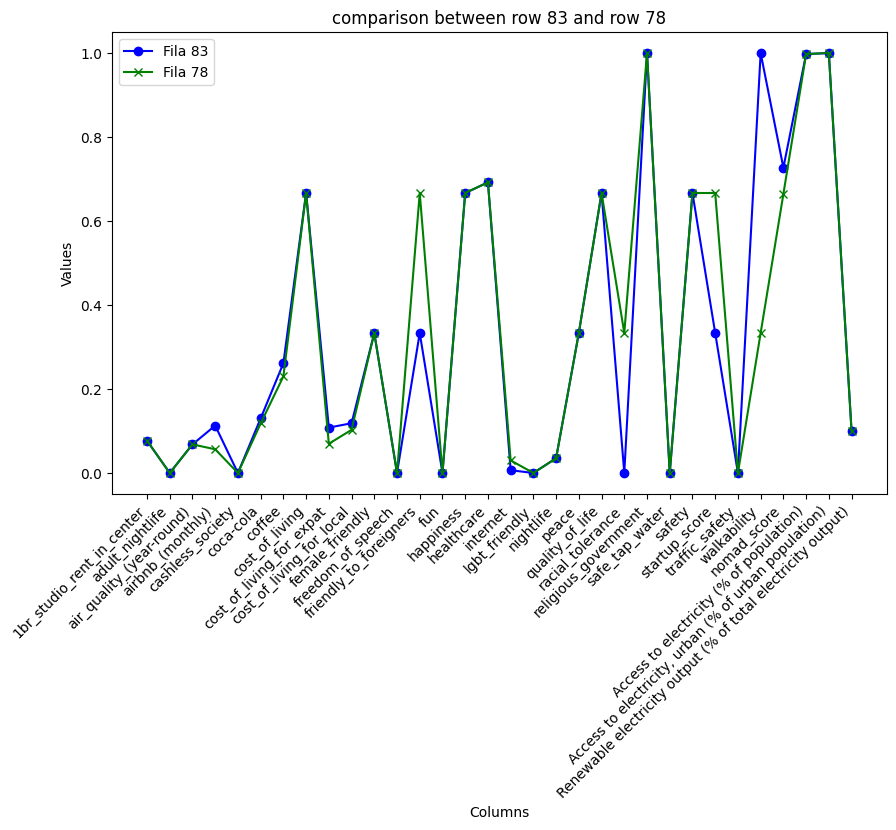

In [27]:
# indexes
reference_row_idx = 83
predicted_row_idx = 78

# Value of the rows
reference_row = df.loc[reference_row_idx, minhash_columns].values
predicted_row = df.loc[predicted_row_idx, minhash_columns].values


plt.figure(figsize=(10, 6))
plt.plot(minhash_columns, reference_row, marker='o', label=f'Fila {reference_row_idx}', color='blue')
plt.plot(minhash_columns, predicted_row, marker='x', label=f'Fila {predicted_row_idx}', color='green')

plt.title(f"comparison between row {reference_row_idx} and row {predicted_row_idx}")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.legend()

plt.xticks(rotation=45, ha="right")

plt.show()

The recommendation is correct because the query presented the city Penang and the system has recommended the user Kuching, both belonging to Malaysia.

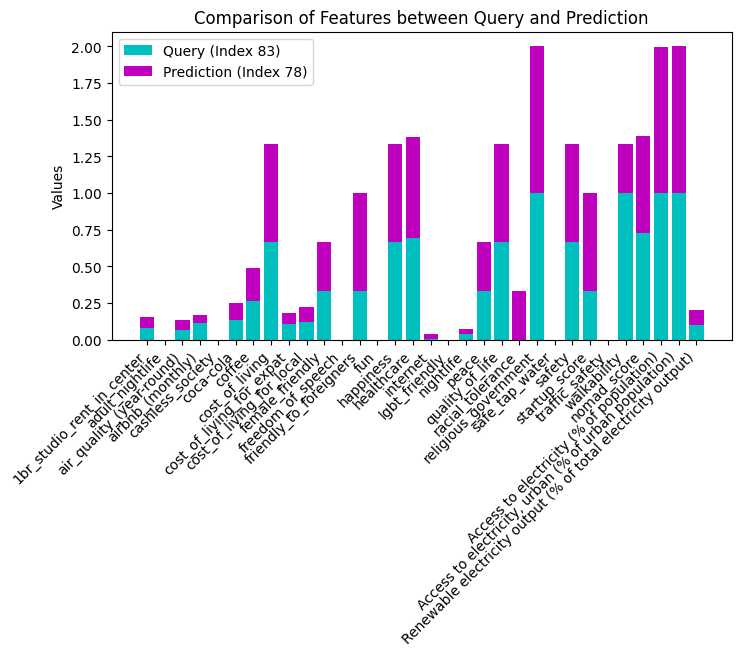

In [28]:
query_row_idx = 83
predicted_row_idx = 78

# Get values of the rows
query_row_values = df.loc[query_row_idx, minhash_columns].values
predicted_row_values = df.loc[predicted_row_idx, minhash_columns].values

# Set up stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['c', 'm']

# Stacked bars for each row
ax.bar(minhash_columns, query_row_values, color=colors[0], label=f'Query (Index {query_row_idx})')
ax.bar(minhash_columns, predicted_row_values, bottom=query_row_values, color=colors[1], label=f'Prediction (Index {predicted_row_idx})')

# Label and legend settings
ax.set_ylabel('Values')
ax.set_title('Comparison of Features between Query and Prediction')
ax.legend()

# Rotate x-axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.savefig('comparison_plot.pdf', bbox_inches='tight', dpi=300)  # Adjust the file name and DPI as needed

# Show the plot
plt.show()

the stacked bars show the values of the characteristics for each sample. Similarity can be inferred by observing similar patterns and trends in the distribution of values between the two samples. If the bars for the corresponding features are visually similar in height and location, it indicates that the two samples share similar characteristics, which could suggest a similarity in the profile or behaviour represented by those specific features.

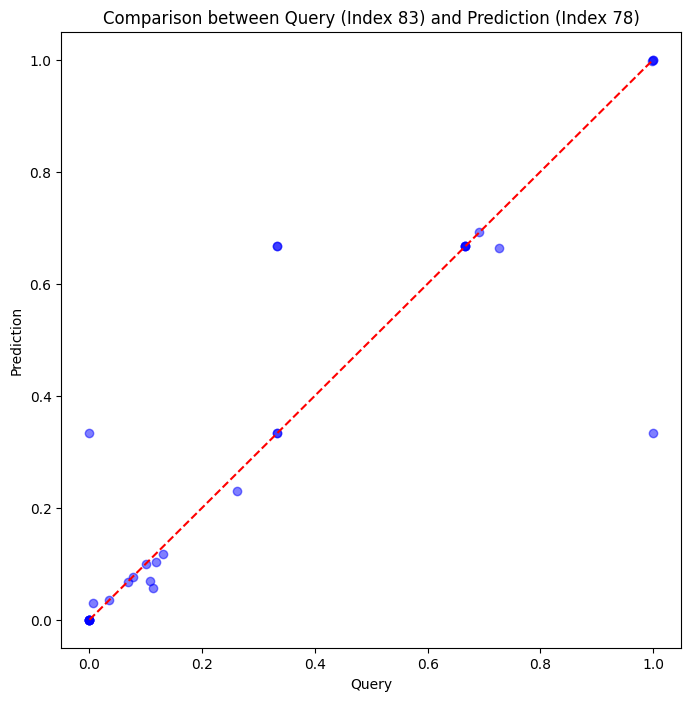

In [29]:
# Row indices to compare
query_row_idx = 83
predicted_row_idx = 78

# Get values from rows
query_row_values = df.loc[query_row_idx, minhash_columns].values
predicted_row_values = df.loc[predicted_row_idx, minhash_columns].values

# Scatter plot configuration
plt.figure(figsize=(8, 8))
plt.scatter(query_row_values, predicted_row_values, alpha=0.5, color='blue')
plt.plot([min(query_row_values), max(query_row_values)], [min(query_row_values), max(query_row_values)], linestyle='--', color='red')  # Identity line

# Label configuration
plt.title(f"Comparison between Query (Index {query_row_idx}) and Prediction (Index {predicted_row_idx})")
plt.xlabel("Query")
plt.ylabel("Prediction")

# Show the plot
plt.show()

**Blue Points**: Each blue point on the graph represents a pair of values from the query and prediction rows at corresponding positions. Each x and y coordinate of the point represents the respective value in the query and prediction rows.

**Dotted Red Identity Line**: The red dotted line represents the identity line, where x and y values are equal. In a scatter plot, this should be a diagonal line from the bottom-left corner to the top-right corner. It serves as a reference to compare values from the query and prediction rows. If all blue points were on this line, it would mean that the values perfectly match.

The presence of blue points near the identity line suggests similarity between the values of the query and prediction rows at those positions. The dispersion around the identity line indicates the magnitude of differences between the values of the query and prediction. The absence of blue points directly on the identity line could be due to values not being exactly equal at those specific positions.

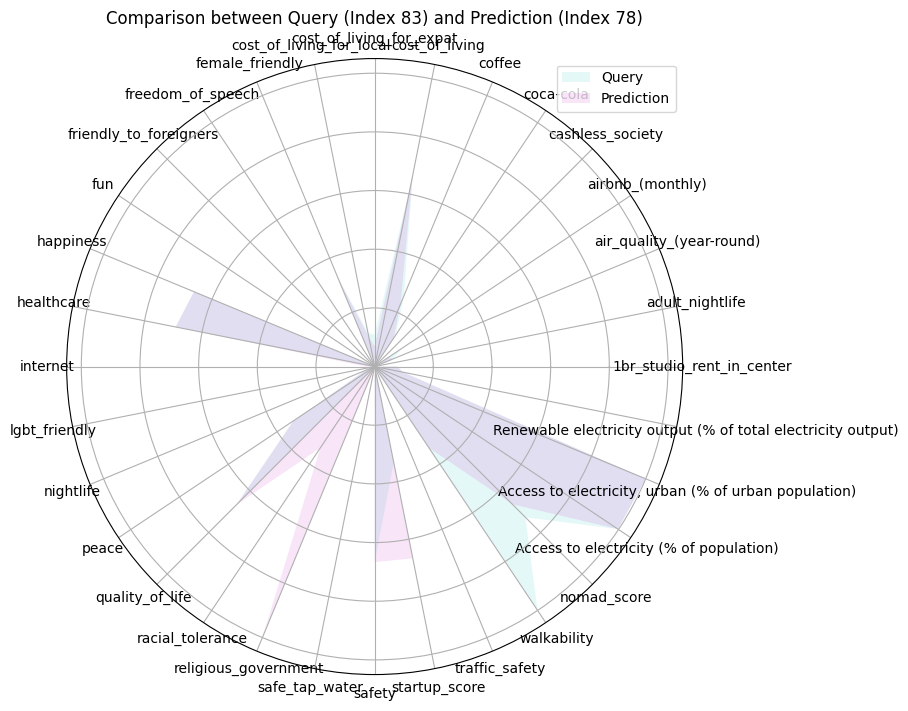

In [30]:
# Indices of the rows you want to compare
query_row_idx = 83
predicted_row_idx = 78

# Get values of the rows
query_row = df.loc[query_row_idx, minhash_columns].values
predicted_row = df.loc[predicted_row_idx, minhash_columns].values

# Column names for the radar plot
column_names = minhash_columns

# Number of columns
num_columns = len(column_names)

# Angle of each axis in the radar plot
angles = np.linspace(0, 2 * np.pi, num_columns, endpoint=False).tolist()

# Close the radar plot
query_row = np.concatenate((query_row, [query_row[0]]))
predicted_row = np.concatenate((predicted_row, [predicted_row[0]]))
angles += angles[:1]

# Configure the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Change colors
ax.fill(angles, query_row, 'c', alpha=0.1, label='Query')  # Cyan
ax.fill(angles, predicted_row, 'm', alpha=0.1, label='Prediction')  # Magenta

# Configure labels and legend
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(column_names)
plt.legend(loc='upper right')

# Add a title
plt.title(f"Comparison between Query (Index {query_row_idx}) and Prediction (Index {predicted_row_idx})")

# Show the plot
plt.show()


## Similar items

#### Cosine similarity
Cosine similarity is a measure commonly used to assess the similarity between two vectors, often applied in the context of similar items. It quantifies the cosine of the angle between these vectors, providing a value between -1 and 1. A value close to 1 implies high similarity, indicating shared characteristics. This metric is particularly useful for item recommendation systems, as it assesses similarity based on the direction of features, regardless of vector magnitudes.

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import time
import psutil

selected_columns = ['cost_of_living', 'fun', 'safety']
features = df[selected_columns]

# Get user preferences within the range of 1-5
user_preferences = {}
for col in selected_columns:
    while True:
        user_input = input(f"Enter a value for {col} (1-5): ")
        try:
            user_value = float(user_input)
            if 1 <= user_value <= 5:
                user_preferences[col] = user_value
                break
            else:
                print("Please enter a value between 1 and 5.")
        except ValueError:
            print("Please enter a valid number.")

# Create a DataFrame with user preferences
user_row = pd.DataFrame([user_preferences])

# Add the user to the features
features = pd.concat([features, user_row], ignore_index=True)
print()

# Impute NaN values with the mean of each column
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
features = features.apply(lambda col: col.fillna(col.mean()), axis=0)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to impute NaN values: {elapsed_time} milliseconds\n")

# Scale the features to ensure they have the same weight
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to scale features: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Calculate cosine similarity between the elements
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
cosine_sim = cosine_similarity(features_scaled, features_scaled)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to calculate cosine similarity: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Get similarities between recommendations and other elements
user_index = len(features) - 1  # Last row is the user
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
user_similarities = cosine_sim[user_index, :]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to get similarities: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Sort the elements based on similarity
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
similar_elements = user_similarities.argsort()[::-1]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time

# Show the recommendations (e.g., the top 3 most similar elements)
top_recommendations = similar_elements[1:4]
print()
print("Top 3 recommendations:", top_recommendations)

# Find the most common country among the top 3 recommendations
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
most_common_city = df.loc[top_recommendations, 'place_slug'].mode()[0]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print()
print(f"Time to find the most common country: {elapsed_time} milliseconds")
print(f"Total memory usage: {end_memory} MB\n")
print("Recommended city based on similarity:", most_common_city)


Time to impute NaN values: 2.186279296875 milliseconds

Time to scale features: 4.138427734375 milliseconds
Memory usage: 0.0 MB

Time to calculate cosine similarity: 7.106201171875 milliseconds
Memory usage: 0.9140625 MB

Time to get similarities: 0.268310546875 milliseconds
Memory usage: 0.0 MB


Top 3 recommendations: [589  36 274]

Time to find the most common country: 3.53662109375 milliseconds
Total memory usage: 4296.47265625 MB

Recommended city based on similarity: daegu-south-korea


#### Jaccard similarity
Now we want to try Jaccard, first we are going to convert columns (1-5 rating), to 
very bad, bad, normal, good, very good.

For example, a value of 1 in the cost variable means that the country is very expensive. A value of 1 for fun means that the country is not fun. And a value of 1 for safety means that the country is not safe.


Jaccard similarity works well with categorical data because it focuses on shared elements, making it effective for variables where values represent distinct categories without inherent numerical relationships. It is robust to variations in set size and ignores the order or frequency of elements, making it suitable for scenarios where the presence or absence of specific categories matters more than their numerical values. In essence, Jaccard similarity aligns with the natural understanding of similarity in categorical variables.

In [32]:
df = pd.read_csv('datasets/nomadlist/df_nomad_sdg.csv')

In [33]:
sample_rows = df.sample(5, random_state=42)[['cost_of_living','fun', 'safety', 'country']]

# Imprimir las filas seleccionadas
print("Selected rows for different values:")
print(sample_rows)

Selected rows for different values:
     cost_of_living  fun  safety        country
468             3.0  3.0     1.0   South Africa
148             1.0  2.0     3.0  United States
302             2.0  3.0     4.0          Spain
355             1.0  3.0     3.0         Sweden
515             3.0  2.0     1.0         Brazil


Next we will categorise the variables in order to calculate the Jaccard Similarity.


In [34]:
df['fun'] = df['fun'].round().astype(int)

In [35]:
df['fun'].value_counts()

fun
2    331
3    209
1    121
4     69
Name: count, dtype: int64

In [36]:
fun_labels = {1: 'Not Fun', 2: 'Somewhat Fun', 3: 'Moderately Fun', 4: 'Very Fun'}

df['fun'] = df['fun'].map(fun_labels)

In [37]:
df['fun'].value_counts()

fun
Somewhat Fun      331
Moderately Fun    209
Not Fun           121
Very Fun           69
Name: count, dtype: int64

In [38]:
df['safety'].value_counts()

safety
3.0    340
2.0    158
4.0    149
1.0     83
Name: count, dtype: int64

In [39]:
# Custom labels for 'safety'
safety_labels = {
    1.0: 'Very Unsafe',
    2.0: 'Unsafe',
    3.0: 'Moderate Safety',
    4.0: 'Safe'
}

# Assuming df is your DataFrame
df['safety'] = df['safety'].map(safety_labels)

In [40]:
df['safety'].value_counts()

safety
Moderate Safety    340
Unsafe             158
Safe               149
Very Unsafe         83
Name: count, dtype: int64

In [41]:
df['cost_of_living'].value_counts()

cost_of_living
3.0    344
1.0    215
2.0    167
4.0      4
Name: count, dtype: int64

In [42]:
# Custom labels for 'cost_of_living'
cost_labels = {
    1.0: 'Very Expensive',
    2.0: 'Expensive',
    3.0: 'Moderate Cost',
    4.0: 'Very Cheap'
}

# Assuming df is your DataFrame
df['cost_of_living'] = df['cost_of_living'].map(cost_labels)

In [43]:
df['cost_of_living'].value_counts()

cost_of_living
Moderate Cost     344
Very Expensive    215
Expensive         167
Very Cheap          4
Name: count, dtype: int64

In [44]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

# Display the non-numeric columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['cost_of_living', 'fun', 'safety', 'region', 'country', 'place_slug'], dtype='object')


In [45]:
# Columns to exclude from standardization
columns_to_exclude = ['cost_of_living', 'safety', 'region', 'country', 'place_slug', 'fun_category']

# Select numerical columns for standardization
numerical_columns = [col for col in df.columns if col not in columns_to_exclude and df[col].dtype != 'object']

df_standardized = df.copy()

# Standardize numerical columns
scaler = StandardScaler()
df_standardized[numerical_columns] = scaler.fit_transform(df_standardized[numerical_columns])

In [46]:
df_standardized.sample(2)

,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,female_friendly,freedom_of_speech,friendly_to_foreigners,fun,happiness,healthcare,internet,lgbt_friendly,nightlife,peace,quality_of_life,racial_tolerance,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug,Access to electricity (% of population),"Access to electricity, urban (% of urban population)",Renewable electricity output (% of total electricity output)
459,-0.221761,-0.298293,-0.649997,-0.781707,0.116871,0.186152,0.360586,Expensive,-0.201242,-0.016088,1.583731,1.341820,0.295034,Moderately Fun,1.708781,0.51957,0.903828,1.047924,1.235573,1.494255,0.311726,2.097327,-0.51707,1.050593,Moderate Safety,0.10715,0.554902,0.601166,1.325687,North America,Canada,abbotsford-canada,0.324462,0.244064,1.440366
174,0.363312,-0.298293,-0.172875,2.005037,0.116871,0.761619,1.195007,Very Expensive,1.097247,0.641564,0.566316,0.177101,1.510874,Somewhat Fun,0.572410,0.51957,-0.289388,0.007809,-1.215135,0.505310,0.311726,0.970884,-0.51707,1.050593,Moderate Safety,0.10715,0.554902,-1.051758,0.678378,North America,United States,park-city-ut-united-states,0.324462,0.244064,-0.669163


In [47]:
df_standardized.isnull().sum()

1br_studio_rent_in_center                                       0
adult_nightlife                                                 0
air_quality_(year-round)                                        0
airbnb_(monthly)                                                0
cashless_society                                                0
coca-cola                                                       0
coffee                                                          0
cost_of_living                                                  0
cost_of_living_for_expat                                        0
cost_of_living_for_local                                        0
female_friendly                                                 0
freedom_of_speech                                               0
friendly_to_foreigners                                          0
fun                                                             0
happiness                                                       0
healthcare

Now our data is categorized and standarized.

We are going to perform jaccard similarity.

In [48]:
import pandas as pd
import numpy as np
import time
import psutil

# Columns for Jaccard similarity
jaccard_columns = ['1br_studio_rent_in_center', 'adult_nightlife', 'air_quality_(year-round)', 'airbnb_(monthly)',
                    'cashless_society', 'coca-cola', 'coffee', 'cost_of_living', 'cost_of_living_for_expat',
                    'cost_of_living_for_local', 'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners',
                    'fun', 'happiness', 'healthcare', 'internet', 'lgbt_friendly', 'nightlife', 'peace',
                    'quality_of_life', 'racial_tolerance', 'religious_government', 'safe_tap_water', 'safety',
                    'startup_score', 'traffic_safety', 'walkability', 'nomad_score',
                    'Access to electricity (% of population)', 'Access to electricity, urban (% of urban population)',
                    'Renewable electricity output (% of total electricity output)']

# Filter non-numeric columns
numeric_columns = df_standardized[jaccard_columns].select_dtypes(include=[np.number]).columns

# Fill NaN values with 0
df_standardized[numeric_columns] = df_standardized[numeric_columns].fillna(0)

# Selecting the rows for Jaccard similarity
query_row = df_standardized.loc[637, numeric_columns].astype(float)
other_rows = df_standardized.loc[:, numeric_columns].astype(float)

# Measure memory before calculation
start_memory = psutil.virtual_memory().used / 1024 / 1024

# Measure time before calculation
start_time = time.time() * 1000  # Start time in milliseconds

# Calculating Jaccard similarities
intersection = other_rows.apply(lambda row: np.sum(np.logical_and(query_row, row)), axis=1)
union = other_rows.apply(lambda row: np.sum(np.logical_or(query_row, row)), axis=1)
jaccard_similarities = intersection / union

# Measure time after calculation
end_time = time.time() * 1000  # End time in milliseconds

# Measure memory after calculation
end_memory = psutil.virtual_memory().used / 1024 / 1024

# Getting indices of top 3 similar rows
top_indices = np.argsort(jaccard_similarities)[-3:][::-1]

# Eliminate the query row from the top recommendations
# Get the indices of the 3 most similar recommendations
top_indices_without_query = top_indices[top_indices != 78][:3]

print("Recommended country:", df_standardized.loc[top_indices_without_query, 'place_slug'].mode()[0])
print()
# Display time and memory information
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Time taken to calculate Jaccard similarity: {elapsed_time} milliseconds\n")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

Recommended country: bruges-belgium

Time taken to calculate Jaccard similarity: 410.81787109375 milliseconds

Memory usage: 11.8984375 MB



Row 673 belongs to a European city (Kaunas, Lithuania) and the recommender system in this case recommends Bruges, Belgium. Therefore the similarity between the sets is high. The system seems to recommend correctly.

## User recommendations
We are now going to perform recommendations using a different approach, one based on users. 

The idea is to suggest places not because of their features, but according to other people who might have similar tastes as you do. 


In the following cells, we are going to train a matrix factorization algorithm. The idea is to predict the missing values from cells in the matrix, given similarities with other users in the matrix. The algorithm is optimized so to make it run faster by implementing stochastic gradient descent instead of gradient descent.

### Collaborative Filtering with matrix factorization
Here, we compute 2 matrices that multiplied together approximate the initial rating matrix. These two matrices are trained iteratively, using Mean Squared Error to get closer to the real matrix.

In [49]:
def matrix_factorization(matrix, size=15, steps=50, eta = 0.01, lambd = 0.005, threshold = 0.01):
    user_len = len(matrix[:, 0])
    item_len = len(matrix[0,:])

    decomp_rows = np.random.rand(user_len,size)
    decomp_cols = np.random.rand(item_len, size)
    
     
    decomp_cols = decomp_cols.T

    for step in tqdm(range(steps)):
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    #Compute gradient of MSE
                    err_ij = matrix[i][j] -np.dot(decomp_rows[i,:], decomp_cols[:,j])

                    for k in range(size):
                        #Update with gradient descent and regularization factor
                        decomp_rows[i][k] = decomp_rows[i][k] + eta * (2*err_ij*decomp_cols[k][j] - lambd * decomp_rows[i][k])
                        decomp_cols[k][j] = decomp_cols[k][j] + eta * (2*err_ij*decomp_rows[i][k] - lambd * decomp_cols[k][j])

        err = np.dot(decomp_rows, decomp_cols)
        e = 0

        #Testing
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j]!=0:
                    e = e + pow(matrix[i][j] - np.dot(decomp_rows[i,:], decomp_cols[:,j]) ,2)

        if e < threshold:
            break
    
    return decomp_rows, decomp_cols.T

In [50]:
#Create the matrices to factorize
matrix_to_factorize_0_1 = np.zeros((len(users), len(cities_list)), dtype='bool')
matrix_to_factorize_rated = np.zeros((len(users), len(cities_list)), dtype='int')

#Populate them
for i,city in enumerate(cities_list):
    for j,(user,city_values) in enumerate(users.items()):
        if city in city_values:
            matrix_to_factorize_0_1[j][i] = 1
            matrix_to_factorize_rated[j][i] = users_cities_rating[user][city]

### Training 

In [51]:
%time decomp_users_0_1, decomp_cities_0_1 = matrix_factorization(matrix_to_factorize_0_1)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:40<33:19, 40.80s/it]


KeyboardInterrupt: 

In [ ]:
%time decomp_users_rated, decomp_cities_rated = matrix_factorization(matrix_to_factorize_rated)

100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.92s/it]

CPU times: user 2min 7s, sys: 12.3 s, total: 2min 20s
Wall time: 1min 58s


### Testing
Here we get the recommendations for every user

In [ ]:
def testing(decomp_rows, decomp_cols, users, cities_list, first_n=10):
    best_cities = []
    for index, (user, cities) in enumerate(users.items()):
        scores = np.dot(decomp_rows[index,:], decomp_cols[:,:])
        scores_aug = [(m,n) for m,n in zip(cities_list , scores)]
        scores_aug_sorted = sorted(scores_aug, key = lambda x:x[1], reverse = True)
        score_sorted_cities = [city for city, score in scores_aug_sorted] 
        best_cities.append(set(score_sorted_cities[:first_n]))
    return best_cities

In [ ]:
best_cities_0_1 = testing(decomp_users_0_1, decomp_cities_0_1.T, users, cities_list)

In [ ]:
best_cities_rated = testing(decomp_users_rated, decomp_cities_rated.T, users, cities_list)

### Doing the same with a SoTA user based recommendation framework
Using a recent library for matrix factorization, we compute the same recommendations to use as ground truth.

In [52]:
model_0_1 = LightFM(no_components=30)
model_rated = LightFM(no_components=30)

matrix_to_factorize_neg_pos = np.zeros((len(users), len(cities_list)), dtype='short')
matrix_to_factorize_rated = np.zeros((len(users), len(cities_list)), dtype='short')


#Populate them
for i,city in enumerate(cities_list):
    for j,(user,city_values) in enumerate(users.items()):
        if city in city_values:
            matrix_to_factorize_0_1[j][i] = 1
            matrix_to_factorize_rated[j][i] = users_cities_rating[user][city]
            '''
            if users_cities_rating[user][city] > 3:
                matrix_to_factorize_rated[j][i] = 1
            else:
                matrix_to_factorize_rated[j][i] = -1
            '''
        


matrix_to_factorize_0_1_coo = sparse.coo_matrix(matrix_to_factorize_0_1)
matrix_to_factorize_rated_coo = sparse.coo_matrix(matrix_to_factorize_rated)

In [53]:
%time model_0_1.fit(matrix_to_factorize_0_1_coo, epochs=1000)

CPU times: user 17.3 s, sys: 55.6 ms, total: 17.3 s
Wall time: 17.4 s


In [54]:
%time model_rated.fit(matrix_to_factorize_rated_coo, epochs=600)

CPU times: user 9.3 s, sys: 2.68 ms, total: 9.31 s
Wall time: 9.31 s


In [55]:
def testing_SoTA(model, users, cities_list, first_n=10):
    best_cities = []
    for index, (user, cities) in enumerate(users.items()):
        #print(f"User has been to {list(users.items())[user_id]}")
        scores = model.predict(index, np.arange(len(cities_list)))
        scores_aug = [(m,n) for m,n in zip(cities_list , scores)]
        scores_aug_sorted = sorted(scores_aug, key = lambda x:x[1], reverse = True)
        score_sorted_cities = [city for city, score in scores_aug_sorted] 
        best_cities.append(set(score_sorted_cities[:first_n]))
    return best_cities

In [56]:
best_cities_sota_0_1 = testing_SoTA(model_0_1, users, cities_list)

In [57]:
best_cities_sota_rated = testing_SoTA(model_rated, users, cities_list)

### Comparing the results

To see how well our algorithm performs with respect to the state of the art one, we computed the overlap between the top 10 recommendations provided by the state of the art algorithm and from our algorithm.

In [ ]:
def overlapping(recommendations, recommendations_sota, first_n=10):
    total_overlap = []
    for i in range(len(recommendations)):
        overlap = recommendations[i] & recommendations_sota[i]
        total_overlap.append(len(overlap)/first_n)
    return sum(total_overlap)/len(total_overlap)

In [ ]:
boolean_overlap = overlapping(best_cities_0_1, best_cities_sota_0_1)
print(f"Overlapping of the boolean model is {boolean_overlap}")

rated_overlap = overlapping(best_cities_rated, best_cities_sota_rated)
print(f"Overlapping of the rated model is {rated_overlap}")


Overlapping of the boolean model is 0.04775819626272875
Overlapping of the rated model is 0.28915463802171293


As it turns out, evaluation turns out to be pretty bad. 
In our opinion, this happens because:
* The dataset it not the most suited to perform this task. We thought that photos locations could be a good reference to see where nomads live, but it might not be.
Also, the rating based on the amount of photos a user took in a place might not be an accurate metric.
* The training loop takes too much time to be run, hence resulting in a bad matrix factorization model.